## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [1]:
from importlib import reload

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
import hockey.hockey_env as h_env

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscretizedHockey(h_env.HockeyEnv):
    def __init__(self, bins, **kwargs):
        super().__init__(**kwargs)

        self.bins = bins
        self.discretized_action_space = spaces.Discrete(self.bins)

### Normal Gameplay

#### Weak Opponent

In [4]:
reload(h_env)
#env = DiscreteActionWrapper(h_env.HockeyEnv(mode=h_env.Mode.NORMAL), bins=8)  # TODO: change bin count?
env = DiscretizedHockey(bins=5, mode=h_env.Mode.NORMAL)

env.reset()

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


(array([-3.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.9236145 , -0.24706793,  0.        ,
         0.        ,  0.        ,  0.        ]),
 {'winner': 0,
  'reward_closeness_to_puck': 0.0,
  'reward_touch_puck': 0.0,
  'reward_puck_direction': 0.0})

In [5]:
DISCOUNT = 0.90
EPS = 0.3
UPDATE_TARGET_FREQ = 30
TAU = 1e-3

agent1 = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent2 = h_env.BasicOpponent(weak=True)

In [108]:
MAX_EPISODES=500
MAX_STEPS=1000

PRINT_FREQ=25

In [101]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    total_reward = 0
    ob_a1, _info = env.reset()
    ob_a2 = env.obs_agent_two()

    for t in range(MAX_STEPS):
        done = False
        trunc = False

        a1_discr = agent1.act(ob_a1)
        a1 = env.discrete_to_continous_action(a1_discr)
        a2 = agent2.act(ob_a2)
        
        ob_a1_new, reward, done, trunc, _info = env.step(np.hstack([a1, a2]))
        total_reward += reward

        agent1.store_transition((ob_a1, a1_discr, reward, ob_a1_new, done))

        ob_a1 = ob_a1_new
        ob_a2 = env.obs_agent_two()

        if done or trunc:
            break

    loss = agent1.train(32)

    losses.extend(loss)
    stats.append([i, total_reward, t+1])
    
    if (i-1) % PRINT_FREQ == 0:
        print("Ep. {}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/500 [00:00<?, ?it/s]

1: Done after 74 steps. Reward: -11.383305906127624
26: Done after 251 steps. Reward: -40.12982185413703
51: Done after 251 steps. Reward: -7.085372058354001
76: Done after 251 steps. Reward: -44.66986259419388
101: Done after 32 steps. Reward: -10.970790559480271
126: Done after 251 steps. Reward: -24.546503882153814
151: Done after 31 steps. Reward: -11.271052851477839
176: Done after 153 steps. Reward: -14.895520571681216
201: Done after 32 steps. Reward: -10.646742814900746
226: Done after 227 steps. Reward: -24.783372902091607
251: Done after 58 steps. Reward: -11.997845606273003
276: Done after 67 steps. Reward: 8.98737046970157
301: Done after 49 steps. Reward: 9.302801224951475
326: Done after 43 steps. Reward: 9.449463654024113
351: Done after 57 steps. Reward: -11.312890480781356
376: Done after 96 steps. Reward: -13.984832191703669
401: Done after 93 steps. Reward: -12.129538855594458
426: Done after 57 steps. Reward: -12.607939027645658
451: Done after 200 steps. Reward: -1

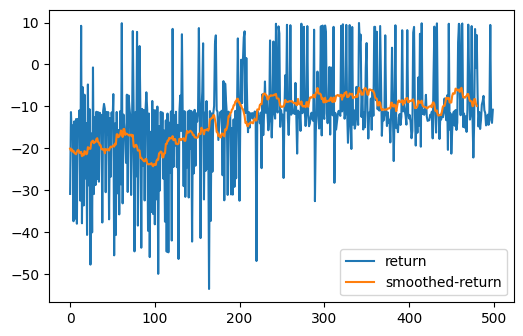

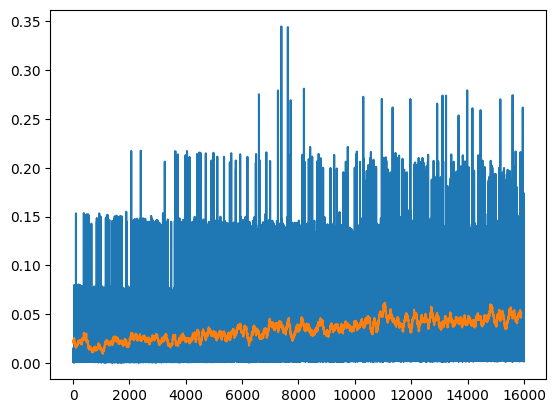

In [102]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np)
plt.plot(running_mean(losses_np, 100))
plt.show()

## Agent Model Saving

In [9]:
STATE_PATH = "./DDQN/models/hockey_discrete_5bins/"

reload(ddqn)

agent1.save_state(STATE_PATH)

## Visualization

In [ ]:
STEPS = 100000

obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(STEPS):
    env.render()
    a1_discr = agent1.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent2.act(obs_agent2)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_agent2 = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {i} steps")
        break


error: display Surface quit

In [104]:
env.close()